In [3]:
import numpy as np
from scipy.signal import butter, filtfilt, hilbert, lfilter, find_peaks, welch, iirnotch
from scipy.integrate import cumtrapz
from scipy.stats import linregress
import pandas as pd
import matplotlib.pyplot as plt
import pywt

In [4]:
def tomV_byBitalino(ADC, n = 10, VCC = 3.3):
    volts = (((ADC/(2**n))-(1/2)) * VCC)/1009
    return volts*1000

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
    
def extract_features(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    amplitude = np.max(signal) - np.min(signal)
    fft_signal = np.fft.fft(signal)
    dominant_frequency = np.argmax(np.abs(fft_signal))
    peaks, _ = find_peaks(signal)
    duration = (peaks[-1]-peaks[0])/len(signal)
    power = np.sum(np.square(signal))/len(signal)
    kurtosis = np.sum((signal - mean)**4)/(len(signal)*std**4)
    coeffs = pywt.wavedec(signal, 'db4', level = 5)
    cA5,cD5,cD4,cD3,cD2,cD1 = coeffs
    wavelet = np.concatenate((cD1, cD2, cD3, cD4, cD5))
    rms = np.sqrt(np.sum(signal * signal)/len(signal))
    area = cumtrapz(signal)
    f,P = welch(signal,fs = 1000, window='hann', noverlap=0,nfft = int(256.))
    area_freq = cumtrapz(P,f,initial=0)
    total_power = area_freq[-1]
    median_freq = f[np.where(area_freq > total_power/2)[0][0]]
    f_max = f[np.argmax(P)]
    # WAMP
    th = 0.25
    diffs = np.abs(np.diff(signal))
    fw = (diffs >= th).astype(int)
    WAMP = np.sum(fw)
    #MMAV
    a = np.ones(len(signal)) * 0.5
    a[int(0.25*len(signal)):int(0.75*len(signal))] = 1.0
    MMAV = np.sum(a * np.abs(signal)) / len(signal)
    #V3
    V3 = np.sum(np.abs(signal)**3)**(1.0/3.0)
    #WL
    WL = np.sum(np.abs(np.diff(signal)))

    features =  {'media': mean,
                 'desviacion_estandar': std,
                 'amplitud': amplitude,
                 'frecuencia_dominante': dominant_frequency,
                 'potencia': power,
                 'kurtosis': kurtosis,
                 #'wavelet': wavelet,
                 'rms': rms,
                 #'area': area,
                 'min_value': np.min(signal),
                 'max_value': np.max(signal),
                 #'area_freq': area_freq,
                 'total_power': total_power,
                 'median_freq': median_freq,
                 'f_max': f_max,
                 'WAMP': WAMP,
                 'MMAV': MMAV,
                 'V3': V3,
                 'WL': WL
                 }
    return features

In [5]:
address = 'Mediciones/'
name = 'Sujeto 1' # Sujeto
ex = 'Cuadriceps' # Ejercicio realizado 
rep = '1'
file = address + name + ' - ' + ex + '/' + name + ' - ' + rep + '.txt'
print(file)
# Mediciones\Sujeto 1 - Cuadriceps\Sujeto 1 - 1.txt

Mediciones/Sujeto 1 - Cuadriceps/Sujeto 1 - 1.txt


Mediciones/Sujeto 1 - Cuadriceps/Sujeto 1 - 1.txt


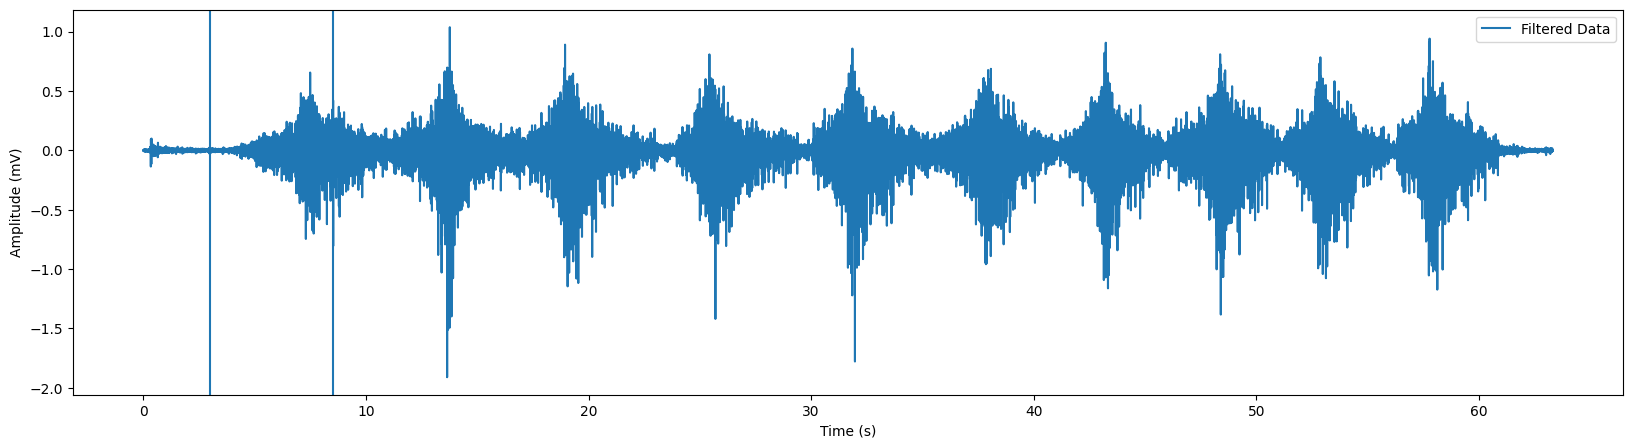

In [6]:
address = 'Mediciones/'
name = 'Sujeto 1' # Sujeto
ex = 'Cuadriceps' # Ejercicio realizado 
rep = '1'
file = address + name + ' - ' + ex + '/' + name + ' - ' + rep + '.txt'
print(file)

fs = 1000; ts = 1/fs # Bitalino's sampling rate
signal = np.genfromtxt(file, delimiter="\t")
signal = signal[:,-2]
signal = tomV_byBitalino(signal)

# Eliminacion de linea base
pre_pro_signal = signal - np.average(signal)

# Filtrado
low_cutoff = 10.0
high_cutoff = 300.0

smooth_signal = butter_bandpass_filter(pre_pro_signal, low_cutoff, high_cutoff, fs)

b,c = iirnotch(60.0, 30.0, fs)
smooth_signal = filtfilt(b,c,smooth_signal)
time = np.arange(len(smooth_signal))*ts

plt.figure(figsize=(20,5))
plt.plot(time, smooth_signal, label = 'Filtered Data')
plt.axvline(3)
plt.axvline(8.5)
plt.ylabel('Amplitude (mV)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [7]:
# Enventanado

# 1er ejercicio (Cuádriceps)

E1_Interval1 = [4.5,11,16.5,23.5,29.5,35.5,41,46,51,56,61.5]
E1_Interval2 = [7.5,13,17.5,21,24.5,28.5,33,38,43.5,48.5,54.5]
E1_Interval3 = [4.5,12.5,18,25.5,31.5,36.5,42,47.5,52,59,65]
E1_Interval4 = [5.5,12.5,18,23,29,34,39.5,44,49,53,57]

N1_Interval1 = [5,14,24,32,40,50,59,67,74,83,91]
N1_Interval2 = [4.5,10.5,17,23,30,36.5,43,50,56.5,63,70]
N1_Interval3 = [4,10.5,17,24,31,40.5,48.5,57,64,71,78]
N1_Interval4 = [3,9.5,17,24,30,37,44,51,57,63.5,70]

S1_Interval1 = [5.5,12,17,22,26.5,31,35.5,40,45,50,54.5]
S1_Interval2 = [4.5,9.5,15,20,25.5,31,36,40.5,45.5,51,56]
S1_Interval3 = [10,16,21,26,31.5,36.5,41.5,47.5,52.5,59,64]
S1_Interval4 = [8.5,13,18,23,28,32.5,38,43,48.5,54,60]

# 2do ejercicio (Femorales)

E2_Interval1 = [4,10,17,23,29,36]
E2_Interval2 = [5,10,15,19.5,25,31.5]
E2_Interval3 = [4,10,16,25,31.5,40]
E2_Interval4 = [6,12,20,28,36,43]

N2_Interval1 = [4,10,17.5,25.5,32,40]
N2_Interval2 = [5,12,19.5,26,32,39]
N2_Interval3 = [7.5,14,21,27.5,34.5,41.5]
N2_Interval4 = [4,10.5,17.5,24,31,38]

S2_Interval1 = [3,8.5,15,21,27,35]
S2_Interval2 = [4,9,14.5,20,25,31]
S2_Interval3 = [4,8,13.5,19,25,31]
S2_Interval4 = [19,24.5,30,36,41,46]

Segments1 = [E1_Interval1,E1_Interval2,E1_Interval3,E1_Interval4,N1_Interval1,N1_Interval2,N1_Interval3,N1_Interval4,S1_Interval1,S1_Interval2,S1_Interval3,S1_Interval4]
Segments2 = [E2_Interval1,E2_Interval2,E2_Interval3,E2_Interval4,N2_Interval1,N2_Interval2,N2_Interval3,N2_Interval4,S2_Interval1,S2_Interval2,S2_Interval3,S2_Interval4]

In [8]:
address = 'Mediciones/'
names = ['Sujeto 1','Sujeto 2','Sujeto 3']
reps = ['1','2','3','4']

#####################################

ex = 'Cuadriceps' 

files1 = []
for name in names:
    for rep in reps:
        file = address + name + ' - ' + ex + '/' + name + ' - ' + rep + '.txt'
        files1.append(file)

cuadriceps = dict(zip(files1, Segments1))

ex = 'Femorales' 

files2 = []
for name in names:
    for rep in reps:
        file = address + name + ' - ' + ex + '/' + name + ' - ' + rep + '.txt'
        files2.append(file)

femorales = dict(zip(files2, Segments2))

In [9]:
dfr = pd.DataFrame()
a = 1
for file in files1:
    fs = 1000; ts = 1/fs # Bitalino's sampling rate
    signal = np.genfromtxt(file, delimiter="\t")
    signal = signal[:,-2]
    signal = tomV_byBitalino(signal)

    # Eliminacion de linea base
    pre_pro_signal = signal - np.average(signal)

    # Filtrado
    low_cutoff = 10.0
    high_cutoff = 300.0

    smooth_signal = butter_bandpass_filter(pre_pro_signal, low_cutoff, high_cutoff, fs)

    b,c = iirnotch(60.0, 30.0, fs)
    smooth_signal = filtfilt(b,c,smooth_signal)
    
    # time = np.arange(len(smooth_signal))*ts
    Intervals = cuadriceps[file] 
    for i in range(10):
        init = Intervals[i]; end = Intervals[i+1]
        fs = 1000; ts = 1/fs # Bitalino's sampling rate
        signalp = smooth_signal[int(init*fs):int(end*fs)]

        # plt.figure(figsize=(20,5))
        # plt.plot(time, signalp, label = 'Datos Originales')
        # plt.ylabel('Filtered Data')
        # plt.xlabel('Time (s)')
        # plt.legend()

        features = extract_features(signalp)
        df = pd.DataFrame(features, index=[a])
        dfr = pd.concat([dfr,df])
    a+=1
dfr.to_csv('Cuadriceps.csv')

In [10]:
dfr = pd.DataFrame()
a = 1
for file in files2:
    fs = 1000; ts = 1/fs # Bitalino's sampling rate
    signal = np.genfromtxt(file, delimiter="\t")
    signal = signal[:,-2]
    signal = tomV_byBitalino(signal)

    # Eliminacion de linea base
    pre_pro_signal = signal - np.average(signal)

    # Filtrado
    low_cutoff = 10.0
    high_cutoff = 300.0

    smooth_signal = butter_bandpass_filter(pre_pro_signal, low_cutoff, high_cutoff, fs)

    b,c = iirnotch(60.0, 30.0, fs)
    smooth_signal = filtfilt(b,c,smooth_signal)
    
    # time = np.arange(len(smooth_signal))*ts
    Intervals = femorales[file] 
    for i in range(5):
        init = Intervals[i]; end = Intervals[i+1]
        fs = 1000; ts = 1/fs # Bitalino's sampling rate
        signalp = smooth_signal[int(init*fs):int(end*fs)]

        # plt.figure(figsize=(20,5))
        # plt.plot(time, signalp, label = 'Datos Originales')
        # plt.ylabel('Filtered Data')
        # plt.xlabel('Time (s)')
        # plt.legend()

        features = extract_features(signalp)
        df = pd.DataFrame(features, index=[a])
        dfr = pd.concat([dfr,df])
    a+=1
dfr.to_csv('Femorales.csv')

In [11]:
#import biosignalsnotebooks as bsnb

#burst_begin, burst_end = bsnb.detect_emg_activations(smooth_signal,fs,smooth_level = 150 , threshold_level=19, time_units=True, plot_result=True)[:2]